# Applied Data Science Capstone &ndash; Final Project

## Preface

This notebook is being provided to fulfill the requirements of the final project for the Coursera **Applied Data Science Capstone** course.


<a id='item1'></a>
# Introduction / Business Problem

Before we get into the data, we begin with a little background on the problem
being faced, and how we aim to solve it.

## Background

Professional life begins for many in a big city, which offers myriad job opportunities as well as
numerous social activities.
After several years of living in the big city, many people tire of the fast pace and limited breathing room,
and opt to move to the suburbs. Sometimes this move is precipitated by changes in family, such as having young children.

A popular misconception is that the suburbs are completely opposite of 
the big city, consisting of small towns with large houses and no social amenities. But, in many areas this
is not true &mdash; the suburbs contain many larger towns and smaller cities that offer a great combination of
city life and non-city life.

New York City is not only the paragon of big cities, but its surroundings provide great
examples of suburban cities and towns. The tri-state area of New York, New Jersey, and Connecticut provide
numerous areas in which to live that echo many of the amenities that New York City offers. 
Many people live in these areas outside of the city and continue to work in New York City, commuting
every day to work in the city.
And if a person living in one of those towns just has to have something that can only be found in NYC,
then it is a short car or train ride away.


## Stamford, CT

The city of Stamford is located in the state of Connecticut, and is just 45 minutes away from New York City by train.
Stamford is a small city, with a population of between 120,000 and 130,000 people.
Stamford is also a varied city, containing a sparsely-populated northern district, a metropolitan downtown area,
and numerous residential areas. The downtown area can feel much like Manhattan, with its numerous
corporate offices, especially those from the financial realm.

## Problem

Since Stamford is such a varied city, it can be difficult for somebody moving from another area to
understand the neighborhoods and what they each offer. Stamford, like most suburban cities, is not so
much of a destination city, so it is unlikely that most people moving into it will have had much
experience with its neighborhoods and amenities.

The problem that is to be solved for many people is where within Stamford, Connecticut to move to.

## Audience

The audience for this report are people who have a vested interest in understanding the neighborhoods
in Stamford, CT. Many of these people will be involved in moving to Stamford and needing to find housing.
Other members of the audience may want to understand the neighborhoods to make business decisions.

1. **People relocating to Stamford**  
People who are relocating to Stamford care where they want to live &mdash; they want to have amenities nearby
that they are interested in, whether they be social, shopping, or educational.
2. **Real estate agents**  
Real estate agents need to know what each neighborhood offers in order to find buyers the best home
when they are looking, and to provide sellers with a best sale price.
3. **Corporations investigating moving to Stamford**  
Companies moving into Stamford need to know about neighborhoods both for their prospective sight,
as well as for the good of their employees.
4. **Businesses investigating opening a store in Stamford**  
Businesses that might be looking to open a physical store in Stamford need to know what other
types of businesses are in prospective neighborhoods, as they want to be able to drive shoppers/clients
to their new storefront, but without having an overabundance of competition.

## Goal

The goal of this project is to investigate the  neighborhoods in Stamford, Connecticut.
The first step will be to determine where the various neighborhoods are located.
The second step will be to understand the characteristics of each neighborhood.

# Data

The dataset that we will be using is from FourSquare.
FourSquare data contains information on numerous points of interest in the city under investigation,
with categories such as restaurants, parks, and schools.

Many of the previous projects in this course have used neighborhoods as they are defined
by exernal datasets. These external datasets have defined neighborhoods by such arbitrary
measures as postal codes and historical/political districts. It does not seem that this
always represents a good measure of what constitutes a neighborhood.

I will be using the FourSquare data itself to define neighborhoods based on
where points of interest are located geographically. I will be using clustering algorithms
as part of this process, and will specifically be using the latitude and longitude
fields from the FourSquare data.

Once the neighborhoods have been defined, I will dig deeper into the characteristics
of each point of interest, and attempt to understand what major amenities define each
neighborhood.


## Libraries

To implement the investigation of the neighborhoods in Stamford, CT, the following Python
libraries and web services will be used:
- Numpy and Pandas (for data analysis)
- GeoPy (for location services)
- Requests (to request data from web services, such as FourSquare)
- Matplotlib (for plotting)
- Sklearn (for machine learning, such as clustering algorithms)
- Folium (to create maps)
- Shapely (to deal with mapping geometry)
- FourSquare (to provide data on points of interest)

### Setup

First we download all the dependencies that we will need.

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import math
import json

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # transform JSON file into a pandas dataframe (was pandas.io.json)

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import folium # map rendering library

from shapely.geometry import shape, Point, Polygon # GeometryCollection
import shapely
import shapely.ops

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of Stamford, CT.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>geo_explorer</em>, as shown below.

In [5]:
address = 'Stamford, CT'

geolocator = Nominatim(user_agent="geo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Stamford, CT are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Stamford, CT are 41.0534302, -73.5387341.


### Helper Functions

In [3]:
# Returns meters per degree in each latitude and longitude
def get_mpd_from_lat_lng(ref_lat, ref_lng):
    # Lat / Long (per Wikipedia; correct within 1 cm):
    # lat_mp = (lat1 + lat2) / 2.0;  // or just use lat1 for slightly less accurate estimate
    lat_mp = ref_lat  # use the ref_lat as the midpoint for calculations
    m_per_deg_lat = 111132.92 - 559.82 * math.cos(2 * lat_mp) + 1.175 * math.cos(4 * lat_mp) - 0.0023 * math.cos(6 * lat_mp)
    m_per_deg_lng = 111412.84 * math.cos(lat_mp) - 93.5 * math.cos(3 * lat_mp) + 0.118 * math.cos(5 * lat_mp)
    return abs(m_per_deg_lat), abs(m_per_deg_lng)

# mpd = meters / degrees; degrees = meters / mpd
def get_degrees_from_meters(meters, mpd):
    # If we are passed a tuple, then return a tuple; otherwise return a scalar
    if type(mpd) is tuple:
        return (meters / mpd[0], meters / mpd[1])
    else:
        return meters / mpd

# Stamford
mpd = get_mpd_from_lat_lng(latitude, longitude)
print("Stamford: mpd = {}".format(mpd))
print("  100 m = {} degrees".format(get_degrees_from_meters(100, mpd)))


Stamford: mpd = (110623.78056005407, 108826.45205953486)
  100 m = (0.0009039647668316057, 0.0009188942403938131) degrees


In [4]:
# Function to get the radius of a circle (in meters) that will contain all points in the given rectangle
def get_containing_radius(height_m, width_m):
    return math.sqrt( (height_m / 2) ** 2 + (width_m / 2) ** 2 )

In [5]:
### Shapely

with open('StamfordCT.geojson', 'r') as f:
    js = json.load(f)

print("There are {} features".format(len(js['features'])))
polygon = shape(js['features'][0]['geometry'])

# Swap the axes: Shapely reads in as (lng, lat) and keeps in that format,
# while Folium wants (lat, lng)
polygon = shapely.ops.transform(lambda x, y, z=None: (y, x), polygon)

print('Stamford Polygon Attributes')
print('  area =', polygon.area)
print('  bounds =', polygon.bounds)  # ((BL), (TR))
print('  length =', polygon.length)
print('  geom_type =', polygon.geom_type)

print('Stamford Bounding Rectangles')
bounding_rect = polygon.envelope
print('  bounding_rect = ', bounding_rect)
# bounding_rect_rotated = polygon.minimum_rotated_rectangle
# print('  bounding_rect_rotated =', bounding_rect_rotated)

# Test
if False:
    # Check if some points are in the polygon
    # point = Point(45.4519896, -122.7924463)
    point = Point(latitude, longitude)
    # point = Point(longitude, latitude)
    print('Point = {}'.format(point))
    # print('The geographical coordinates of Stamford, CT are {}, {}.'.format(latitude, longitude))

    in_polygon = polygon.contains(point)
    if in_polygon: # polygon.contains(point):
        print('Point IN polygon')
    else:
        print('No, Point NOT in polygon')
    
# Create a polygon from a rect, with geo format that Folium will like (i.e. [lat, lng]) 
def geo_create_polygon_from_rect(rect):
    top = rect[0][0]
    bottom = rect[1][0]
    left = rect[0][1]
    right = rect[1][1]
    point_list = [ [top, left], [top, right], [bottom, right], [bottom, left] ]
    return shapely.geometry.asPolygon(point_list)


There are 1 features
Stamford Polygon Attributes
  area = 0.014149034182739387
  bounds = (40.9642048, -73.63393, 41.179929, -73.4954009)
  length = 0.6178721423919542
  geom_type = Polygon
Stamford Bounding Rectangles
  bounding_rect =  POLYGON ((40.9642048 -73.63393000000001, 41.179929 -73.63393000000001, 41.179929 -73.49540090000001, 40.9642048 -73.49540090000001, 40.9642048 -73.63393000000001))


#### Create a map of Stamford with neighborhoods superimposed on top.

In [37]:
# create map of New York using latitude and longitude values
map_stamford_empty = folium.Map(location=[latitude, longitude], zoom_start=11)
# map_stamford_empty

state_geo_file = 'Connecticut.geojson'
city_geo_file = 'StamfordCT.geojson'
greenwich_geo_file = 'GreenwichCT.geojson'

def geo_style_state(feature):
    return {
        # Border (weight is pixels); Also: stroke (bool to disable), lineCap, lineJoin, dashArray, dashOffset
        'color': '#000000', 'weight': 1.2, 'opacity': 0.2,
        # Fill; Also: fill (bool to disable), fillRule (determines inside of shape), bubblingMouseEvents
        'fillColor': '#0000ff', 'fillOpacity': 0.05
    }
def geo_highlight_state(feature):
    return {
        'fillOpacity': 0.1
    }

def geo_style_stamford(feature):
    return {
        'fillOpacity': 0.2, 'weight': 1.6, 'fillColor': '#00cc00'
    }

def geo_highlight_stamford(feature):
    return {
        'fillOpacity': 0.08
    }

def geo_style_rect(feature):
    return {
        'fillOpacity': 0, 'weight': 1.2, 'fillColor': '#00cccc'
    }

# Add overlay to show where city is
geo_ct = folium.GeoJson(state_geo_file, name='Connecticut', style_function=geo_style_state,
              highlight_function=geo_highlight_state, # tooltip="Connecticut",
              overlay=True, control=True, show=True).add_to(map_stamford_empty)
geo = folium.GeoJson(city_geo_file, name='Stamford, CT', style_function=geo_style_stamford,
              highlight_function=geo_highlight_stamford, tooltip="Stamford, CT",
              overlay=True, control=True, show=True).add_to(map_stamford_empty)

# CircleMarker does NOT have a style_function
folium.vector_layers.CircleMarker((latitude, longitude), radius=4, weight=1,
                                  fill=True, fill_opacity=1.0, fill_color="#000000",
                                  color="#000000", tooltip="City").add_to(map_stamford_empty)

# Create a bounding rectangle (manually)
rect_left = polygon.bounds[1]
rect_right = polygon.bounds[3]
rect_top = polygon.bounds[2]
rect_bottom = polygon.bounds[0]
top_left = [rect_top, rect_left]
bottom_right = [rect_bottom, rect_right]
folium.vector_layers.CircleMarker((rect_top, rect_left), radius=3, weight=1,
                                  fill=True, fill_opacity=1.0, fill_color="#aa0000",
                                  color="#000000", tooltip="TL").add_to(map_stamford_empty)
folium.vector_layers.CircleMarker((rect_bottom, rect_right), radius=3, weight=1,
                                  fill=True, fill_opacity=1.0, fill_color="#aa0000",
                                  color="#000000", tooltip="BR").add_to(map_stamford_empty)
rect_bounds = [ top_left, bottom_right ]
rb = folium.vector_layers.Rectangle(rect_bounds, weight=1, color="#882222").add_to(map_stamford_empty)

# Bounding Rectangles as found by Shapely
# folium.vector_layers.Polygon(bounding_rect.exterior.coords,
#                              name='Stamford, CT (bounding rect)',
#                              weight=1, color="#00aaaa").add_to(map_stamford_empty)
# folium.vector_layers.Polygon(bounding_rect_rotated.exterior.coords,
#                              name='Stamford, CT (rotated bounding rect)',
#                              weight=1, color="#aaaa00").add_to(map_stamford_empty)

lat_mpd, lng_mpd = get_mpd_from_lat_lng(latitude, longitude)

#rect = [ [latitude + 0.001, longitude - 0.001], [latitude - 0.001, longitude + 0.001] ]
#r1 = folium.vector_layers.Rectangle(rect).add_to(map_stamford_empty)
if False:  # old constants
    lat_start =  0.020
    lat_end   = -0.020
    lng_start = -0.020
    lng_end   =  0.020
    lat_step_size = 0.004
    lng_step_size = 0.004
    lat_mpd, lng_mpd = get_mpd_from_lat_lng(latitude, longitude)
    print("Lat = {} to {} in {} m steps".format(lat_start*lat_mpd, lat_end*lat_mpd, lat_step_size*lat_mpd))
    print("Lng = {} to {} in {} m steps".format(lng_start*lng_mpd, lng_end*lng_mpd, lng_step_size*lng_mpd))

# Alt: create values from meters
meters_step = 2000
lat_step_size = meters_step / lat_mpd
lng_step_size = meters_step / lng_mpd

# Alt: Create from bounding rectangle
lat_start = rect_top
lat_end   = rect_bottom
lng_start = rect_left
lng_end   = rect_right
print("Lat = {} to {} in {} degree steps".format(lat_start, lat_end, -lat_step_size))
print("Lng = {} to {} in {} degree steps".format(lng_start, lng_end, lng_step_size))
# Note: radius is in METERS (not in degrees)
cell_radius = get_containing_radius(lat_step_size * lat_mpd, lng_step_size * lng_mpd)
print(f"Radius of containing circle is {cell_radius} m")

# A helper line used to empirically determine where the southernmost land is
lat_southernmost_land = 41.016
#southernmost_land_line = [[lat_southernmost_land, -73.63393], [lat_southernmost_land, -73.4954009]]
#folium.vector_layers.PolyLine(southernmost_land_line, weight=4, color="#ff6666").add_to(map_stamford_empty)
    
# Test first square

count = 0
count_intersect = 0
for lat_inx in np.arange(lat_start, lat_end, -lat_step_size):
    # If we are now south of the southernmost land, stop processing tiles
    if lat_inx < lat_southernmost_land:
        break
    for lng_inx in np.arange(lng_start, lng_end, lng_step_size):
        count += 1
        # relative: rect = [ [latitude + lat_inx, longitude - lng_inx], [latitude - lat_inx, longitude + lng_inx] ]
        # Use the (lat_inx, lng_inx) as top-left, and calculate bottom-right
        rect = [ [lat_inx, lng_inx],  [lat_inx - lat_step_size, lng_inx + lng_step_size] ]
        # if the Stamford polygon intersects the current rectangle, then it is valid (color it)
        poly_rect = geo_create_polygon_from_rect(rect)
        if poly_rect.intersects(polygon):
            count_intersect += 1
            kwargs = { 'weight': 0.8, 'color': '#000088', 'fill_color': '#0000aa', 'fill_opacity': 0.12}
        else:
            kwargs = { 'stroke': False, 'weight': 0.8, 'color': '#000088', 'fill_opacity': 0}
        # r1 = folium.vector_layers.Rectangle(rect, weight=0.8, color="#000088").add_to(map_stamford_empty)
        r1 = folium.vector_layers.Rectangle(rect, **kwargs).add_to(map_stamford_empty)

        center = [lat_inx - 0.5 * lat_step_size, lng_inx + 0.5 * lng_step_size]

        # Test Code
        if count == 2:  # 56=Darien, 60=Greenwich
            # Note: radius is in METERS (not in degrees)
            test_location = center
            folium.vector_layers.Circle(center, cell_radius, weight=1, color='#ff8800').add_to(map_stamford_empty)

print("{} of {} rectangles intersect with the Stamford polygon".format(count_intersect, count))

lc = folium.map.LayerControl(position='topright').add_to(map_stamford_empty) #, collapsed=True, autoZIndex=True, **kwargs)

map_stamford_empty

Lat = 41.179929 to 40.9642048 in -0.018079295336632113 degree steps
Lng = -73.63393 to -73.4954009 in 0.018377884807876263 degree steps
Radius of containing circle is 1414.213562373095 m
53 of 80 rectangles intersect with the Stamford polygon


#### Define Foursquare Credentials and Version

In [38]:
CLIENT_ID = 'BOGTGAFH5WKN13HQNJU0K5U3ZEUS1DLFI5JU0P2CX1ZTQGBE'
CLIENT_SECRET = '5MIOG3NT1VQ22FLEJPQJ1RND2QAFVF5QEMBXATCLXNHOOBRZ'
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: BOGTGAFH5WKN13HQNJU0K5U3ZEUS1DLFI5JU0P2CX1ZTQGBE
CLIENT_SECRET:5MIOG3NT1VQ22FLEJPQJ1RND2QAFVF5QEMBXATCLXNHOOBRZ


In [39]:
LIMIT = 100      # API doc claims max is 50; offset param is used to search for more (but may also be limited to 50?)
radius = cell_radius    # maximum is 100,000 m
# Note: Could use "near=Stamford, CT" as part of query instead of lat/long

# To get a JSON struct of categories:
# GET https://api.foursquare.com/v2/venues/categories
# Docs: https://developer.foursquare.com/docs/api-reference/venues/categories

# Extra params
# section = food, drinks, coffee, shops, arts, outdoors, sights, trending, nextVenues
# categoryId = <>
# https://developer.foursquare.com/docs/api/venues/categories = get a JSON representation of all categories (in tree)
# These are the top-level category IDs
#  4d4b7104d754a06370d81259 = Arts & Entertainment
#  4d4b7105d754a06372d81259 = College & University
#  4d4b7105d754a06373d81259 = Event
#  4d4b7105d754a06374d81259 = Food
#  4d4b7105d754a06376d81259 = Nightlife Spot (subs = Bar, Brewery, Lounge, Night Market, Nightclub, Other Nightlife, Strip Club)
#  4d4b7105d754a06377d81259 = Outdoors & Recreation
#  4d4b7105d754a06375d81259 = Professional & Other Places (incl Medical Center, School, Spiritual Center)
#  4e67e38e036454776db1fb3a = Residence (subs = Assisted Living, Home (private), Housing Development, Residential Building (Apartment / Condo), Trailer Park)
#  4d4b7105d754a06378d81259 = Shop & Service
#  4d4b7105d754a06379d81259 = Travel & Transport

url_params = "&time=any&day=any"

#### Now, let's get some venues that are in the search radius.

First, create the GET request URL.

In [40]:
def make_url(latitude, longitude, radius, offset=0, category_id=None):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}" \
          "&v={}&ll={},{}&radius={}&offset={}&limit={}".format(
        CLIENT_ID, CLIENT_SECRET, VERSION,
        latitude, longitude,
        radius, offset, LIMIT)
    if category_id:
        url += "&categoryId={}".format(category_id)
    # sortByDistance=1  # distance instead of 'relevance'
    url += url_params
    return url


In [151]:
# Test of make_url()
#offset = 0
#url = make_url(latitude, longitude, radius, offset)
#url

Send the GET request and examine the resutls

In [45]:
# See what gets returned by the API
#results = requests.get(url).json()
#results

#len(results['response']['groups'][0]['items'])

#results['response']['groups'][0]['items'][0]

# See what keys each array entry has
#results['response']['groups'][0]['items'][0].keys()

# Useful: venue
# Ignore: reasons, referralId
#poi = results['response']['groups'][0]['items'][0]['venue']
#poi.keys()
# poi['name']  # Gives name

After looking at these keys, we can ignore the 'delivery' and 'photos' keys.

In [46]:
if False:
    # Gives various human-readable addresses, as well as lat/lng
    print('location:', str(poi['location']))
    print('categories:', poi['categories'])

We want to keep the following keys:
- location.(lat, lng)  # for clustering
- location.city  # to verify that POI is in fact in the city under search
- location.postalCode  # for potential future analysis
- location.address  # for posterity
- categories.id  # for analysis
- categories.name  # for labelling
- categories.primary  # for checking heirarchy
- venue.id  # for comparing and avoiding duplicates if doing multiple searches

In [73]:
def get_dataframe_from_results(results):
    venues = results['response']['groups'][0]['items']
    if len(venues) == 0:
        return pd.DataFrame()
    nearby_venues = json_normalize(venues) # flatten JSON
    nv = nearby_venues

    # Rename some of the columns that we want to keep
    # lat, lng
    # The we can delete 'venue'location' entries
    cols_to_keep = ['venue.name', 'venue.location.address', 'venue.location.city', 'venue.location.state',
                    'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode', 'venue.id']
                    #'venue.categories'] #'venue.categories.name', 'venue.categories.id', 'venue.categories.primary']
    if all([item in nv.columns for item in cols_to_keep]):
        df = nv[cols_to_keep]

        # df.loc[0]['venue.categories'][0] #['name']

        # For each record/row, grab the first category 'name' and 'id' (if they exist)
        categories = [[i[0]['name'], i[0]['id']] if len(i) > 0 else ['Unknown', 'Unknown'] for i in nv['venue.categories']]
        # Create a DataFrame
        df_cat = pd.DataFrame(categories)
        df_cat.columns = ['category_name', 'category_id']
        df = df.join(df_cat)

        df.rename(columns={"venue.name": "name", "venue.location.address": "address",
                           "venue.location.city": "city", "venue.location.state": "state",
                           "venue.location.lat": "latitude", "venue.location.lng": "longitude",
                           "venue.location.postalCode": "zipcode", "venue.id": "venue_id"}, inplace=True)
    else:
        # Return an empty DataFrame
        df = pd.DataFrame()

    return df


In [74]:
def get_pois(latitude, longitude, radius, category_id):
    offset = 0
    total_returned = 0
    df = pd.DataFrame()

    while True:
        url = make_url(latitude, longitude, radius, offset, category_id)
        # print('Calling:', url)
        results = requests.get(url).json()
        num_available = results['response']['totalResults']
        print('num_available =', num_available)
        num_returned = len(results['response']['groups'][0]['items'])
        df_temp = get_dataframe_from_results(results)
        if df_temp.empty:
            break

        # Else we have data to deal with
        # print(df_temp.loc[0])
        df = df.append(df_temp, ignore_index=True)

        # Break out of loop if we have retrieved all of the entries
        offset += num_returned
        total_returned += num_returned
        print('total_returned =', total_returned)
        if total_returned >= num_available:
            break

    df.fillna(0, inplace=True)

    return df

In [75]:
if False:
    # Need to set category_id for this to work
    url = make_url(latitude, longitude, radius, offset, category_id)
    print('Calling:', url)
    results = requests.get(url).json()
    num_available = results['response']['totalResults']

    results
    dx = get_dataframe_from_results(results)
    type(dx)
    dx.empty

In [50]:
# A small helper class
class Category:
    def __init__(self, name, categories_to_query, categories_to_delete):
        self.name = name
        if type(categories_to_query) is list:
            self.categories_to_query = categories_to_query
        elif categories_to_query is None:
            self.categories_to_query = []
        else:
            self.categories_to_query = [categories_to_query]
        if type(categories_to_delete) is list:
            self.categories_to_delete = categories_to_delete
        elif categories_to_delete is None:
            self.categories_to_delete = []
        else:
            self.categories_to_delete = [categories_to_delete]
    def query_string(self):
        return ",".join(self.categories_to_query)
        # return str(self.categories_to_query)

cat1 = Category("Stuff", ["abc", "def", "ghi"], None)
cat2 = Category("More Stuff", "xyz", None)
cat3 = Category("Extra Stuff", "top", None)


In [51]:
#cat1.query_string()
cat1.categories_to_delete

[]

In [52]:
# Use our helper class
top_level_categories = [
    # Arts & Entertainment
    # We query at the top level, but remove "Art Gallery"
    Category("Arts & Entertainment",
             "4d4b7104d754a06370d81259",   # + Arts & Entertainment
             "4bf58dd8d48988d1e2931735"),  # - Art Gallery

    # College & University (top is "4d4b7105d754a06372d81259")
    # We only query for: Community College, Trade School, University
    # This avoids duplication of entries for classrooms, quads, cafeterias, parking
    Category("College & University",
             ["4bf58dd8d48988d1a2941735",   # + Community College
              "4bf58dd8d48988d1ad941735",   # + Trade School
              "4bf58dd8d48988d1ae941735"],  # + University
             None),

    # Event ("4d4b7105d754a06373d81259")
    # We do NOT query, as these are not permanent points of interest
    
    # Food
    # Query for all!
    Category("Food", "4d4b7105d754a06374d81259", None),
    
    # Nightlife Spot
    # Query for all!
    Category("Nightlife Spot", "4d4b7105d754a06376d81259", None),

    # Outdoors & Recreation
    # Query for all, but then delete items that are often associated with residences
    #   (gyms, roof deck) and delete Summer Camp since it is not permanent
    Category("Outdoors & Recreation",
             "4d4b7105d754a06377d81259",     # + Outdoors & Recreation
             ["4bf58dd8d48988d175941735",    # - Gym / Fitness Center
              "4bf58dd8d48988d176941735",    # - Gym
              "4bf58dd8d48988d133951735",    # - Roof Deck
              "52e81612bcbc57f1066b7a10"]),  # - Summer Camp

    # Professional & Other Places
    # Query for Library, Post Office, School (might need to limit), Social Club, Spiritual Center
    # "4d4b7105d754a06375d81259": "Professional & Other", # (incl Medical Center, School, Spiritual Center)
    Category("Other Places",
             ["4bf58dd8d48988d12f941735",   # + Library
              "4bf58dd8d48988d172941735",   # + Post Office
              "52e81612bcbc57f1066b7a33"],  # + Social Club
             None),

    # Residence ("4e67e38e036454776db1fb3a")
    # We do NOT query, as these do not define what amenities are available in a neighborhood

    # Shop & Service
    # Query for all!
    Category("Shop & Service",
             "4d4b7105d754a06378d81259",    # + Shop & Service
            ["52f2ab2ebcbc57f1066b8b3f"]),  # - Lawyer

    # Travel & Transport ("4d4b7105d754a06379d81259")
    # Query only for sub-categories of Travel & Transport that are relevant to commuters:
    #   Train Station, Tram Station, Airport, Bus Station, Bus Stop, Light Rail Station, Metro Station
    Category("Travel & Transport",
             ["4bf58dd8d48988d129951735",   # + Train Station
              "52f2ab2ebcbc57f1066b8b51",   # + Tram Station
              "4bf58dd8d48988d1ed931735",   # + Airport
              "4bf58dd8d48988d1fe931735",   # + Bus Station
              # "52f2ab2ebcbc57f1066b8b4f",   # + Bus Stop
              "4bf58dd8d48988d1fc931735",   # + Light Rail Station
              "4bf58dd8d48988d1fd931735"],  # + Metro Station
             ["4bf58dd8d48988d12a951735",   # - Train (individual train numbers)
              "52f2ab2ebcbc57f1066b8b4f"])  # - Bus Stop
]

In [76]:
df_cat2 = get_pois(test_location[0], test_location[1], radius, "4d4b7105d754a06378d81259")

num_available = 1


In [77]:
df_cat2

Empty DataFrame
Columns: []
Index: []

In [79]:
def get_all_cell_pois(lat, lng, radius):
    df_cell = pd.DataFrame()

    #for category_id, val in top_level_categories.items():
    for cat in top_level_categories:
        print(f"Processing {cat.name}")
        # if not cat.name == "Food":
        #     continue
        # df_cat = get_pois(latitude, longitude, radius, cat.query_string())
        df_cat = get_pois(lat, lng, radius, cat.query_string())
        # If there are no POIs, then try the next iteration
        if df_cat.empty:
            continue
        # df_cat['top_category'] = top_level_categories[category_id]
        df_cat['top_category'] = cat.name

        # Delete (drop) any entries that are not located in Stamford
        num_not_stamford = df_cat[df_cat.city != "Stamford"].shape[0]
        if num_not_stamford > 0:
            df_cat.drop(df_cat[df_cat.city != "Stamford"].index, inplace=True)
            print(f"  Removed {num_not_stamford} entries that are not in Stamford")
            # print("  Now have {} entries".format(df_cat.shape[0]))

        # Delete (drop) any entries that have a category_id that we want to ignore
        for subcat_to_delete in cat.categories_to_delete:
            print(f"  Deleting unwanted category {subcat_to_delete}")
            df_cat.reset_index()    # make sure indexes are good before trying to delete
            orig_count = df_cat.shape[0]
            df_cat.drop(df_cat[df_cat.category_id == subcat_to_delete].index, inplace=True)
            print(f"    Deleted {orig_count - df_cat.shape[0]} entries")

        df_cell = df_cell.append(df_cat, ignore_index=True)

    # Remove duplicates
    orig_count = df_cell.shape[0]
    df_cell.drop_duplicates(subset=['venue_id'], inplace=True)
    num_deleted = orig_count - df_cell.shape[0]
    if num_deleted > 0:
        print(f"  Removed {num_deleted} duplicate entries")

    return df_cell

# Test
# df_test = get_all_cell_pois(test_location[0], test_location[1], radius)


In [80]:
df = pd.DataFrame()
count = 0
count_intersect = 0
for lat_inx in np.arange(lat_start, lat_end, -lat_step_size):
    # TODO: REMOVE THIS, ONLY HERE FOR TESTING: Limit number of cells processed
    # if count_intersect > 4:
    #     break
    # If we are now south of the southernmost land, stop processing tiles
    if lat_inx < lat_southernmost_land:
        break
    for lng_inx in np.arange(lng_start, lng_end, lng_step_size):
        count += 1

        # Use the (lat_inx, lng_inx) as top-left, and calculate bottom-right
        rect = [ [lat_inx, lng_inx],  [lat_inx - lat_step_size, lng_inx + lng_step_size] ]
        center = [lat_inx - 0.5 * lat_step_size, lng_inx + 0.5 * lng_step_size]

        # if the Stamford polygon intersects the current rectangle, then it is valid (get POIs in it)
        poly_rect = geo_create_polygon_from_rect(rect)
        if poly_rect.intersects(polygon):
            count_intersect += 1
            # TODO: Make the call
            df_cell = get_all_cell_pois(center[0], center[1], radius)
            df = df.append(df_cell, ignore_index=True)
        else:
            pass

print("Processed {} of {} rectangles that intersect with the Stamford polygon".format(count_intersect, count))

# Remove duplicates
print("Removing duplicates")
orig_count = df.shape[0]
df.drop_duplicates(subset=['venue_id'], inplace=True)
print(f"  Removed {orig_count - df.shape[0]} entries")


Processing Arts & Entertainment
num_available = 0
Processing College & University
num_available = 0
Processing Food
num_available = 0
Processing Nightlife Spot
num_available = 0
Processing Outdoors & Recreation
num_available = 3
total_returned = 3
  Removed 2 entries that are not in Stamford
  Deleting unwanted category 4bf58dd8d48988d175941735
    Deleted 0 entries
  Deleting unwanted category 4bf58dd8d48988d176941735
    Deleted 0 entries
  Deleting unwanted category 4bf58dd8d48988d133951735
    Deleted 0 entries
  Deleting unwanted category 52e81612bcbc57f1066b7a10
    Deleted 0 entries
Processing Other Places
num_available = 0
Processing Shop & Service
num_available = 2
total_returned = 2
  Removed 1 entries that are not in Stamford
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b3f
    Deleted 0 entries
Processing Travel & Transport
num_available = 0
Processing Arts & Entertainment
num_available = 0
Processing College & University
num_available = 0
Processing Food
num_available

num_available = 0
Processing Arts & Entertainment
num_available = 0
Processing College & University
num_available = 0
Processing Food
num_available = 0
Processing Nightlife Spot
num_available = 0
Processing Outdoors & Recreation
num_available = 2
Processing Other Places
num_available = 0
Processing Shop & Service
num_available = 3
total_returned = 3
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b3f
    Deleted 0 entries
Processing Travel & Transport
num_available = 0
Processing Arts & Entertainment
num_available = 1
total_returned = 1
  Deleting unwanted category 4bf58dd8d48988d1e2931735
    Deleted 1 entries
Processing College & University
num_available = 0
Processing Food
num_available = 2
total_returned = 2
Processing Nightlife Spot
num_available = 1
total_returned = 1
Processing Outdoors & Recreation
num_available = 0
Processing Other Places
num_available = 0
Processing Shop & Service
num_available = 6
total_returned = 6
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b3f
   

num_available = 0
Processing Shop & Service
num_available = 24
total_returned = 24
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b3f
    Deleted 2 entries
Processing Travel & Transport
num_available = 1
Processing Arts & Entertainment
num_available = 2
total_returned = 2
  Removed 1 entries that are not in Stamford
  Deleting unwanted category 4bf58dd8d48988d1e2931735
    Deleted 0 entries
Processing College & University
num_available = 0
Processing Food
num_available = 1
Processing Nightlife Spot
num_available = 0
Processing Outdoors & Recreation
num_available = 4
total_returned = 4
  Removed 3 entries that are not in Stamford
  Deleting unwanted category 4bf58dd8d48988d175941735
    Deleted 0 entries
  Deleting unwanted category 4bf58dd8d48988d176941735
    Deleted 0 entries
  Deleting unwanted category 4bf58dd8d48988d133951735
    Deleted 0 entries
  Deleting unwanted category 52e81612bcbc57f1066b7a10
    Deleted 0 entries
Processing Other Places
num_available = 0
Processing Sho

num_available = 3
total_returned = 3
  Removed 1 entries that are not in Stamford
Processing Food
num_available = 26
total_returned = 26
  Removed 1 entries that are not in Stamford
Processing Nightlife Spot
num_available = 5
total_returned = 5
Processing Outdoors & Recreation
num_available = 20
total_returned = 20
  Removed 2 entries that are not in Stamford
  Deleting unwanted category 4bf58dd8d48988d175941735
    Deleted 4 entries
  Deleting unwanted category 4bf58dd8d48988d176941735
    Deleted 6 entries
  Deleting unwanted category 4bf58dd8d48988d133951735
    Deleted 0 entries
  Deleting unwanted category 52e81612bcbc57f1066b7a10
    Deleted 0 entries
Processing Other Places
num_available = 3
total_returned = 3
  Removed 1 entries that are not in Stamford
Processing Shop & Service
num_available = 53
total_returned = 53
  Removed 2 entries that are not in Stamford
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b3f
    Deleted 0 entries
Processing Travel & Transport
num_availabl

num_available = 8
total_returned = 8
Processing Shop & Service
num_available = 135
total_returned = 100
num_available = 135
total_returned = 135
  Removed 3 entries that are not in Stamford
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b3f
    Deleted 14 entries
Processing Travel & Transport
num_available = 5
total_returned = 5
  Deleting unwanted category 4bf58dd8d48988d12a951735
    Deleted 0 entries
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b4f
    Deleted 3 entries
  Removed 5 duplicate entries
Processing Arts & Entertainment
num_available = 48
total_returned = 48
  Deleting unwanted category 4bf58dd8d48988d1e2931735
    Deleted 34 entries
Processing College & University
num_available = 10
total_returned = 10
Processing Food
num_available = 123
total_returned = 100
num_available = 123
total_returned = 123
Processing Nightlife Spot
num_available = 25
total_returned = 25
Processing Outdoors & Recreation
num_available = 53
total_returned = 53
  Removed 1 entries that are n

num_available = 6
total_returned = 6
Processing Shop & Service
num_available = 165
total_returned = 100
num_available = 165
total_returned = 165
  Removed 2 entries that are not in Stamford
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b3f
    Deleted 3 entries
Processing Travel & Transport
num_available = 40
total_returned = 40
  Removed 1 entries that are not in Stamford
  Deleting unwanted category 4bf58dd8d48988d12a951735
    Deleted 13 entries
  Deleting unwanted category 52f2ab2ebcbc57f1066b8b4f
    Deleted 13 entries
  Removed 10 duplicate entries
Processing Arts & Entertainment
num_available = 5
total_returned = 5
  Deleting unwanted category 4bf58dd8d48988d1e2931735
    Deleted 0 entries
Processing College & University
num_available = 0
Processing Food
num_available = 28
total_returned = 28
  Removed 1 entries that are not in Stamford
Processing Nightlife Spot
num_available = 5
total_returned = 5
Processing Outdoors & Recreation
num_available = 28
total_returned = 28
  Del

In [81]:
df

name  \
0                               Rockrimmon Country Club   
1                                  Optimum WiFi Hotspot   
2                                    Dorothy Heroy Park   
3                                          Shanti Bithi   
4               Lifted Spirits Bar Concierge & Staffing   
5                                 BECKER ASSOCIATES LLC   
7                               CCB Communications, LLC   
10                                    Long Ridge Tavern   
11                                        Cafe Oo La La   
13                     Stamford Land Conservation Trust   
14                      Long Ridge Swim And Tennis Club   
15                  Sentry Electric/Tarizia Development   
16                   Long Ridge Road Plumbing & Heating   
18    Scott and Scott, Inc. Home Inspections Stamfor...   
19    Scott and Scott, Inc. Home Inspections Stamfor...   
22                               The Black Goose Grille   
23                                 277 Blackberry Drive   
26                             LaRocca's Country Market   
30                           Carpet Cleaning Norwalk CT   
31                           Jim Todd Construction, LLC   
34                          Garage Door Repair Stamford   
35                                       Cearley Cabana   
37                                            Lads Dane   
38                               Great Wine Made Simple   
40                                 Marguerite Daskam Co   
41                                  Corner Liquor Store   
44         Ridgefield Electric/At Your Service Electric   
45                                      Courthouse Cafe   
46                                        Glorious Food   
48                                     cedar lodge farm   
49                                    Classical Pilates   
52                               Country Wine & Spirits   
58                              Sotire Basketball Arena   
61                                     Mianus River Dam   
62                         Appliance Repair in Stamford   
63                                        Iron Mountain   
64                                        lakescape llc   
65                                   Supplement Doctors   
66                                     Cheesecake House   
67                               Hanauer Adventure Land   
69                       Spiral's Mac & Cheese Stamford   
70                                 Hungry Mind Bookshop   
71                                        Easy Baby LLC   
73                                             mteamllc   
78                                   Chestnut Hill Park   
79                         North Stamford Little League   
80                    Chestnut Hill Park Baseball Field   
81                                    Mehlquist Gardens   
84                      Stamford Museum & Nature Center   
85                                            Herbalife   
86                                          CI Junction   
89    Stamford Museam & Nature Center's Nature's Pla...   
90                                       Heckscher Farm   
91                          Norrh Stamford Neighborhood   
92                                       Animal Embassy   
94                              Interior Design Camp CT   
95                          Garage Door Repair Stamford   
96                      Evans Construction Company, LLC   
98                      The Finishing Touch Landscaping   
99                             Evans Paving Enterprises   
100                            Evans Paving Enterprises   
101                             Frontier Communications   
105                                   Michael Ale House   
114                                 G and G Productions   
115                                Angel Food Bake Shop   
116                                North Stamford Video   
117                            Madonia Restaurant & Bar   
118                                    

In [6]:
filename = "df_all.csv"

In [83]:
# Save File
df.to_csv(filename, index=None)


In [7]:
# Read File; make sure zipcodes are strings to ensure leading 0s are kept
dr = pd.io.parsers.read_csv(filename, dtype={'zipcode': 'str'})
print(f"File has {dr.shape[0]} records")
dr[:5]

File has 1475 records


name                   address  \
0                  Rockrimmon Country Club        2949 Long Ridge Rd   
1                     Optimum WiFi Hotspot        2949 Long Ridge Rd   
2                       Dorothy Heroy Park  1-99 Riding Stable Trail   
3                             Shanti Bithi                         0   
4  Lifted Spirits Bar Concierge & Staffing               23 Flora Pl   

       city state   latitude  longitude zipcode                  venue_id  \
0  Stamford    CT  41.160919 -73.594320   06903  4c30a3ed3896e21e09cbe590   
1  Stamford    CT  41.160381 -73.596077   06903  5993321edd12f839eb08a7e0   
2  Stamford    CT  41.174521 -73.560152   06903  4d98abac0caaa1431450b2b3   
3  Stamford    CT  41.170521 -73.563129       0  518e607f498e1abaeea11f88   
4  Stamford    CT  41.165900 -73.562070   06903  5d29772b01cd310023647d76   

      category_name               category_id           top_category  
0       Golf Course  4bf58dd8d48988d1e6941735  Outdoors & Recreation  
1  Business Service  5453de49498eade8af355881         Shop & Service  
2              Park  4bf58dd8d48988d163941735  Outdoors & Recreation  
3     Garden Center  4eb1c0253b7b52c0e1adc2e9         Shop & Service  
4     Event Service  5454152e498ef71e2b9132c6         Shop & Service

#### Create a map of Stamford with the POIs superimposed on top.

In [8]:
# create map of New York using latitude and longitude values
map_stamford_2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name in zip(dr['latitude'], dr['longitude'], dr['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        weight=0.8,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stamford_2)  
    
map_stamford_2

In [9]:
dr.shape

(1475, 11)

## 4. Cluster Neighborhoods

Now we are going to cluster the neighborhoods based on their latitude and longitude.
Note that this is different than what has been done in previous class assigments.
The goal of this project is to see where neighborhoods have naturally clustered based
on the points of interest that are present in those neighborhoods.

First we create a new DataFrame that contains *only* the latitude and longitude for each point of interest,
since these are the only data values that we want to use for clustering.

In [10]:
dr_sub = dr[ ['latitude', 'longitude'] ]
dr_sub.columns = ['latitude', 'longitude']
print(f"There are {dr_sub.shape[0]} entries; the first five are:")
dr_sub[:5]


There are 1475 entries; the first five are:


latitude  longitude
0  41.160919 -73.594320
1  41.160381 -73.596077
2  41.174521 -73.560152
3  41.170521 -73.563129
4  41.165900 -73.562070

### First we look for an optimal k in the k-Means algorithm

Before we segment into our final clusters, we need to determine what the optimal number
of clusters should be. This is done running the k-Means algorithm iteratively over
a number of values of k, and then looking at two graphs to see where we have reached a point
of diminishing returns if we add more clusters.

In [11]:
# run k-means clustering
sse = []
silhouette_coeffs = []
for k in range(1, 20):
    kmeans_engine = KMeans(n_clusters=k, random_state=0)
    kmeans = kmeans_engine.fit(dr_sub)
    sse.append(kmeans.inertia_)
    if k > 1:
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
        silhouette_coeffs.append(silhouette_score(dr_sub, kmeans.labels_))
    


The two values that we plot are the Sum of Squares Error and the Silhouette Coefficients.

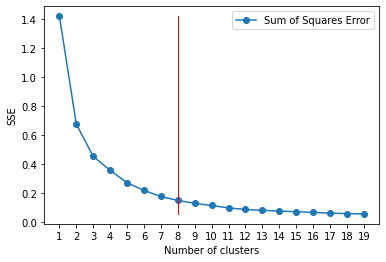

In [12]:
# Plot the Sum of Squares Error
plt.figure()
plt.plot(range(1, 20), sse, marker="o", label="Sum of Squares Error")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.legend()
plt.xticks(np.arange(1, 20, 1))

# Draw vertical line at the chosen k
# plot() accepts arguments in format ([x1, x2], [y1, y2])
plt.plot([8, 8], [min(sse), max(sse)], 'r-', lw=1)

plt.show()

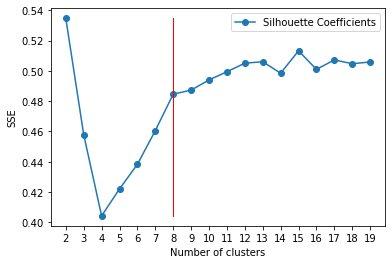

In [13]:
# Plot the Silhouette Coefficients
plt.figure()
plt.plot(range(2, 20), silhouette_coeffs, marker="o", label="Silhouette Coefficients")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.legend()
plt.xticks(np.arange(1, 20, 1))

# Draw vertical line at the chosen k
# ([x1, x2], [y1, y2])
plt.plot([8, 8], [min(silhouette_coeffs), max(silhouette_coeffs)], 'r-', lw=1)

plt.show()

### We have looked at the graphs for both SSE and silhouette coefficients, and have chosen 8 as the optimal number of clusters.

Now we run the *k*-means algorithm on our data to cluster the neighborhood into 8 clusters.

In [14]:
# set number of clusters
num_kclusters = 8

In [15]:
# run k-means clustering
kmeans_engine = KMeans(n_clusters=num_kclusters, random_state=0)
kmeans = kmeans_engine.fit(dr_sub)


Let's create a new dataframe that includes the cluster label for each point of interest.

In [19]:
# Add clustering labels
ds = dr.copy()
ds.insert(0, 'cluster', kmeans.labels_)
ds[100:105]


cluster                                 name             address  \
100        0                        Tennis Courts   1620 Newfield Ave   
101        0  High Ridge Printing and Copy Center  1009 High Ridge Rd   
102        0                         Trader Joe's  1041 High Ridge Rd   
103        0      Robeks Fresh Juices & Smoothies  1125 High Ridge Rd   
104        0                             Pet Valu  1131 High Ridge Rd   

         city state   latitude  longitude zipcode                  venue_id  \
100  Stamford    CT  41.113743 -73.535467   06905  4e42e5cd628484fb528f9c03   
101  Stamford    CT  41.105877 -73.547750   06905  4d65917a4e1ea1cd150352b9   
102  Stamford    CT  41.107104 -73.547389   06905  52a9f6c111d23d49aabc1aac   
103  Stamford    CT  41.108745 -73.546824   06905  4bbb763ec585a593d943b6b7   
104  Stamford    CT  41.108793 -73.547056   06905  5206cecd498ea3fd07cf8991   

     category_name               category_id           top_category  
100   Tennis Court  4e39a956bd410d7aed40cbc3  Outdoors & Recreation  
101    Post Office  4bf58dd8d48988d172941735           Other Places  
102  Grocery Store  4bf58dd8d48988d118951735         Shop & Service  
103  Smoothie Shop  52f2ab2ebcbc57f1066b8b41         Shop & Service  
104      Pet Store  4bf58dd8d48988d100951735         Shop & Service

In [20]:
print(ds.shape) #.tail() # check the last columns!
# Need to remove rows with a "Cluster Labels" value of NaN (caused by 0 venues in some neighborhoods)
#toronto_fixed = toronto_merged.dropna(axis="index")
#print(toronto_fixed.shape)

(1475, 12)


Finally, let's visualize the resulting clusters

In [21]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_kclusters)
ys = [i + x + (i*x)**2 for i in range(num_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ds['latitude'], ds['longitude'], ds['zipcode'], ds['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Note:** In the above map, the clusters _are_ based on geography.

## Analyze each cluster

Now we analyze each cluster to see what categories are most prevalent in each.

In [22]:
# First look at how many entries are in each cluster
ds.groupby(by='cluster').count()

name  address  city  state  latitude  longitude  zipcode  venue_id  \
cluster                                                                       
0         185      185   185    185       185        185      185       185   
1         394      394   394    394       394        394      394       394   
2         119      119   119    119       119        119      119       119   
3         202      202   202    202       202        202      202       202   
4          54       54    54     54        54         54       54        54   
5         167      167   167    167       167        167      167       167   
6         197      197   197    197       197        197      197       197   
7         157      157   157    157       157        157      157       157   

         category_name  category_id  top_category  
cluster                                            
0                  185          185           185  
1                  394          394           394  
2                  119          119           119  
3                  202          202           202  
4                   54           54            54  
5                  167          167           167  
6                  197          197           197  
7                  157          157           157

In [23]:
ds['cluster'].value_counts(normalize=True)

1    0.267119
3    0.136949
6    0.133559
0    0.125424
5    0.113220
7    0.106441
2    0.080678
4    0.036610
Name: cluster, dtype: float64

In [49]:
dc = ds.groupby(['cluster','top_category'])['cluster'].count()


In [50]:
dc

cluster  top_category         
0        Arts & Entertainment       8
         Food                      33
         Nightlife Spot             4
         Other Places               2
         Outdoors & Recreation     18
         Shop & Service           118
         Travel & Transport         2
1        Arts & Entertainment      14
         College & University       9
         Food                     114
         Nightlife Spot            23
         Other Places               7
         Outdoors & Recreation     33
         Shop & Service           181
         Travel & Transport        13
2        Arts & Entertainment       9
         College & University       2
         Food                      26
         Nightlife Spot             6
         Other Places               2
         Outdoors & Recreation     12
         Shop & Service            60
         Travel & Transport         2
3        Arts & Entertainment       5
         College & University       1
         Food      

In [133]:
dd = pd.DataFrame()
for i in range(8):
    dd = dd.append(dc[i])
dd = dd.reset_index(drop=True)
dd.fillna(0, inplace=True)
dd

Arts & Entertainment   Food  Nightlife Spot  Other Places  \
0                   8.0   33.0             4.0           2.0   
1                  14.0  114.0            23.0           7.0   
2                   9.0   26.0             6.0           2.0   
3                   5.0   39.0             3.0           5.0   
4                   1.0   10.0             5.0           0.0   
5                   7.0   27.0             7.0           3.0   
6                   8.0   43.0             7.0           1.0   
7                   5.0   29.0             4.0           3.0   

   Outdoors & Recreation  Shop & Service  Travel & Transport  \
0                   18.0           118.0                 2.0   
1                   33.0           181.0                13.0   
2                   12.0            60.0                 2.0   
3                   20.0           126.0                 3.0   
4                   12.0            26.0                 0.0   
5                   11.0           110.0                 2.0   
6                   28.0           107.0                 3.0   
7                   20.0            91.0                 3.0   

   College & University  
0                   0.0  
1                   9.0  
2                   2.0  
3                   1.0  
4                   0.0  
5                   0.0  
6                   0.0  
7                   2.0

In [146]:
# Convert to percentages -- each entry is the percent of POIs in the cluster are of that type
dd = dd.iloc[:,:].apply(lambda x: x / x.sum() * 100, axis=1)

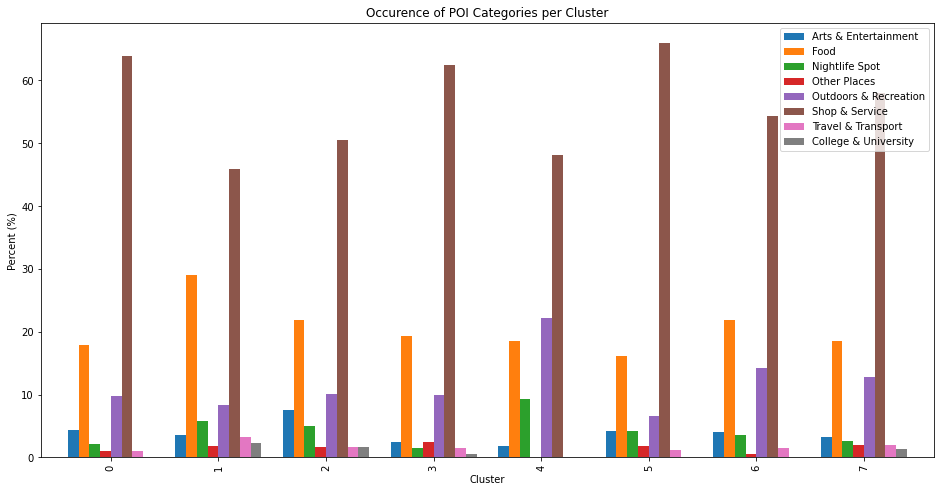

In [150]:
# pd.DataFrame.plot.bar(dd)
dd.plot(kind='bar', figsize=(16, 8), width=0.8)
plt.title("Occurence of POI Categories per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Percent (%)")
plt.show()


## Conclusion

By looking at the above graph, we can decide what types of points of interest each
cluster/neighborhood is most represented by.

The "Shop & Service" category is the most prevalent for all clusters, as might be expected because
it covers a large range of entry types, from customer-facing shopping to landscaping services.
Because it is so large for all clusters, we will ignore it in defining neighborhood characteristics.

For the most part, the clusters have very similar offerings in terms of points of interest.
The following clusters have a slightly different profile;
- 1 = lots of food; also has most transport options
- 2 = well respresented by arts & entertainment
- 4 = has more outdoor & recreation, lots of nightlife

One conclusion that we can draw is that all of the neighborhoods offer a good range of points of interest.
This means that a person or business moving to Stamford will be able to choose from neighborhoods
based on other characteristics, such as by how much housing costs in that neighborhood.
And if a person has very specific need or desire, there are a few neighborhoods that might provide
an environment that is just a little more to their liking!

### Fini

This notebook was created for week 3 of the Coursera course **Applied Data Science Capstone**.

<hr>

Copyright &copy; 2020 Jonathan Lowthert. This notebook and its source code are released under the terms of the [MIT License](https://opensource.org/licenses/MIT).